In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
import glob

import warnings
warnings.filterwarnings("ignore")

In [2]:
def coupling_matrix(N, weights, val=False):
    if val==True:
        return J1
    J = np.zeros((N, N))
    k = 0
    for i in range(N-1):
        for j in range(N-1, i, -1):
            J[i,j] = weights[k]
            k = k + 1
    J = J + np.transpose(J)
    # ensuring that J is symmetric
    
    return J

def voltage(alpha, beta, N, Tmax, plot=0):  
    x = np.zeros((N, Tmax))   #the value of the voltages
    f = np.zeros((N, Tmax))   #the function f
    g = np.random.normal(0, 0.01, size=(N, Tmax)) #gaussian noise
    J = coupling_matrix(N, weights)

    for k in range(Tmax-1):
        for n in range(N):
            sum1 = 0
            if beta != 0:
                for j in range(N):
                    sum1 += J[j, n]*x[j, k]
            f[n, k] = alpha*x[n, k] + beta*sum1                              #equation 3.2 in the paper
            x[n, k+1] = (np.cos(f[n, k] + g[n, k] - np.pi/4))**2 - 0.5       #equation 3.1 in the paper
        if plot==1:
            spins = np.sign(x[:, k+1])
            plt.imshow(spins.reshape(10,10))
            plt.show()
    return x

def energy(Tmax, N, alpha, beta, array=0):
    x = voltage(alpha, beta, N, Tmax)
    E = np.zeros(Tmax)
    for k in range(Tmax):
        for i in range(N):
            for j in range(i, N):
                E[k] += J[i, j]*np.sign(x[i, k])*np.sign(x[j, k])
    if array == 0:
        return -E[-1]
    if array == 1:
        return -E

def spins(alpha, beta, N, Tmax):
    x = voltage(alpha, beta, N, Tmax)
    spins = np.sign(x[:, -1])
    return spins

def plot_approximation(gpr, X, X_sample, Y_sample, X_next=None, show_legend=False):
    mu, std = gpr.predict(X, return_std=True)
    plt.fill_between(X.ravel(), 
                     mu.ravel() + 1.96 * std, 
                     mu.ravel() - 1.96 * std, 
                     alpha=0.1) 
    plt.plot(X, mu, 'b-', lw=1, label='Surrogate function')
    plt.plot(X_sample, Y_sample, 'kx', mew=3, label='samples')
    if X_next:
        plt.axvline(x=X_next, ls='--', c='k', lw=1)
    if show_legend:
        plt.legend()
        
def assign_weights(filename, density=50):
    global weights
    weights = []

    with open(filename, 'r') as file:
        for line in file:
            words = line.split()
            if len(words) == 3:
                weight = int(words[2])
                weights.append(weight)

    file.close()

    if density != 50:
        for i in range(len(weights)):
            if np.random.randint(0,100) >= density:
                weights[i] = 0
            else:
                weights[i] = -abs(weights[i])

    for i in range(len(weights)):
        if weights[i] == 1:
                     # changing the weights from {-1,1} to {-1,0}
            weights[i] = 0

    print("density is ", abs(100*sum(weights)/len(weights)))

    Tmax = 90
    E_init = np.zeros(2).reshape(-1, 1)
    Z = np.arange(0,3.1,0.1) # alpha values
    noise = 0.1

    p = [0.5, -0.5, -len(weights)]
    roots = np.roots(p)

    N = int(np.round(roots[roots>0][0]))
    
    return weights, N, Z, E_init, Tmax, noise

In [4]:
def bay_opt(Z, alpha, optimal_energy, N, Tmax, E_init, noise, beta_max, delta=0.2, num=10, plot_graph=1):
    start = time.time()
    for z_index in range(alpha, alpha+1):
        beta_min = N*(1-Z[z_index])/(abs(sum(weights)))
        
        #beta_max = num*beta_min
        #beta_max = (np.pi/(2*delta) - 0.9)/(abs(max(sum(coupling_matrix(N, weights)))))
        
        bounds = np.array([[beta_min, beta_max]])
        #bounds = np.array([[1e-10, 1]])
        
        #X_init = np.array([[0.1], [0.9]])
        X_init = np.array([[beta_min], [beta_max]])
        E_init[0] = energy(Tmax, N, Z[z_index], X_init[0])
        E_init[1] = energy(Tmax, N, Z[z_index], X_init[1])
        
        #n_calls = int((9*N*(1-Z[z_index])/(abs(sum(weights))))/0.003) - 2
        n_calls = 4
        
        n52 = ConstantKernel(1.0) * Matern(length_scale=0.1, length_scale_bounds=(1e-150, 10), nu=2.5)
        gpr = GaussianProcessRegressor(kernel=n52, alpha=noise**2)

        r = gp_minimize(lambda x: energy(Tmax, N, Z[z_index], np.array(x)), 
                        bounds.tolist(),
                        base_estimator=gpr,
                        acq_func='EI',      # expected improvement
                        xi=0.1,            # exploitation-exploration trade-off
                        n_calls=n_calls,         # number of iterations
                        n_random_starts=0,  # initial samples are provided
                        x0=X_init.tolist(), # initial samples
                        y0=E_init.ravel())

        gpr.fit(r.x_iters, r.func_vals)

        optimal_energy[0].append(r.x[0])
        optimal_energy[1].append(r.fun)
        optimal_energy[2].append(Z[z_index])
        
        #The first row stores the value of beta
        #The second row stores the value of the accuracy 
        #The third row stores the value of alpha

        # Plot the fitted model and the noisy samples
        if plot_graph == 1:
            X = np.linspace(bounds[:, 0], bounds[:, 1], 1000).reshape(-1, 1) #beta values for plotting
            plt.title("alpha = {}".format(Z[z_index]))
            plt.xlabel("beta")
            plt.ylabel("Energy")
            plot_approximation(gpr, X, r.x_iters, r.func_vals, show_legend=True)
            plt.show()

    end = time.time()
    print(end-start)
    
    answers = [optimal_energy, r, end-start, n_calls, beta_min, beta_max]
    
    return answers

Optimal values of $\alpha$ and $\beta$ that achieve the ground state configuration.

In [123]:
file_paths = glob.glob("D:\IITG Onedrive\OneDrive - Indian Institute of Technology Guwahati\IITG\Beyond Course\TIM\Datasets\Files\*.rud")

In [ ]:
answers = [[], [], [], [], [], []]
i = 0

for file_name in file_paths:
    
    weights, N, Z, E_init, Tmax, noise = assign_weights(file_name)

    answers[i] = bay_opt(Z, 9, [[], [], []], N, Tmax, E_init, noise)

    optimal_energy = answers[i][0]
    beta_g = optimal_energy[0][0]
    alpha_g = optimal_energy[2][0]

    print("N = ", N, "Time taken = ", answers[i][2])
    print(optimal_energy)
    
    i += 1
    #print("n_calls = ", answers[3])

In [ ]:
C = 0.5*(sum(weights)+optimal_energy[1][0])
print(C)

In [5]:
start = time.time()
filename = "C:\\Users\\adhru\\graphgen\\WK5_2.rud"
weights, N, Z, E_init, Tmax, noise = assign_weights(filename, density=100)
end = time.time()
print("time taken for this = ", end-start, "s")

density is  -100.0
time taken for this =  0.05201244354248047 s


In [7]:
J = coupling_matrix(N, weights)

In [33]:
N1 = 8
J1 = np.zeros((8,8))
J1[0:5, 0:5] = J

In [37]:
x = np.zeros((N1, Tmax))   #the value of the voltages
f = np.zeros((N1, Tmax))   #the function f
g = np.random.normal(0, 0.01, size=(N1, Tmax)) #gaussian noisex = voltage(alpha, beta, N1, Tmax, x, f, g, J1)
E = np.zeros(Tmax)

x = voltage(0.9, 0.2, N1, Tmax, x, f, g, J1)

for k in range(Tmax):
    for i in range(N1):
        for j in range(i, N1):
            E[k] += -J1[i, j]*np.sign(x[i, k])*np.sign(x[j, k])

-2.0

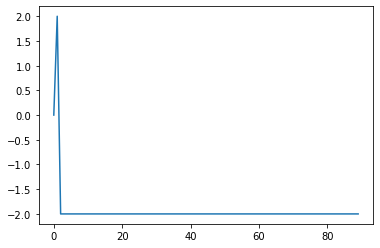

In [38]:
plt.plot(E)
E[-1]

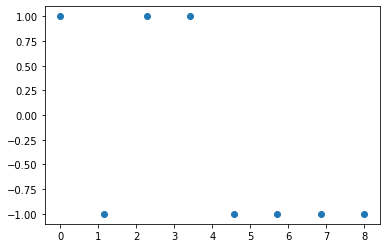

In [39]:
plt.scatter(np.linspace(0,N1,N1), np.sign(x[:,-1]))

In [7]:
10*N*(1-Z[9])/(abs(sum(weights)))

0.4999999999999999

In [8]:
J = coupling_matrix(N, weights)
beta_values = []
for i in range(N):
    W = sum(J[i,:])
    beta_values.append((-np.pi/2 - Z[9]*0.2)/(W*0.2))

beta_max = max(beta_values)
beta_max

2.1884954084936203

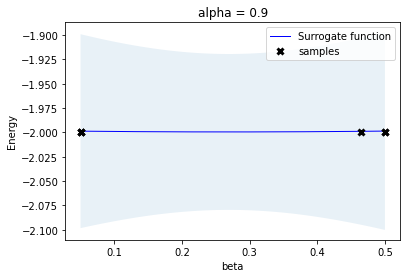

1.2819252014160156


In [9]:
answers_1 = bay_opt(Z=Z, alpha=9, optimal_energy=[[], [], []], N=N, 
                    Tmax=Tmax, E_init=E_init, beta_max=10*N*(1-Z[9])/(abs(sum(weights))),
                    noise=noise, num=9)

In [15]:
answers_1[0]

[[0.08333333333333331], [-2.0], [0.9]]

In [16]:
0.5*(answers_1[0][1][0]+sum(weights))

-4.0

In [18]:
alpha_g = answers_1[0][2][0]
beta_g = answers_1[0][0][0]

alpha=0.9, beta=0.08333333333333331


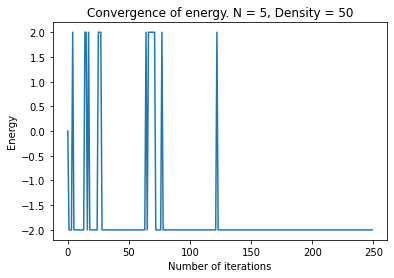

In [20]:
y = energy(250, N, alpha_g, beta_g, 1)
plt.title("Convergence of energy. N = {}, Density = {}".format(N, 50))
plt.plot(y)
plt.ylabel("Energy")
plt.xlabel("Number of iterations")
print("alpha={}, beta={}".format(alpha_g, beta_g))

In [49]:
C = 0.5*(sum(weights)+optimal_energy[1][0])
print(C)
C = 0.5*(y[-1]+sum(weights))
print(C)
y[-100]

-1421.0
-1431.0


-363.0

In [425]:
values = []

start = time.time()
for i in range(9,10):
    k = 0
    beta_min = N*(1-Z[z_index])/(abs(sum(weights)))
    beta_max = 20*beta_min
    for j in np.linspace(beta_min,beta_max,4):
        values.append(energy(Tmax, N, i/10, j, weights))
        k += 1
end = time.time()
print("Time: {}s".format(end-start))

Time: 187.03681445121765s


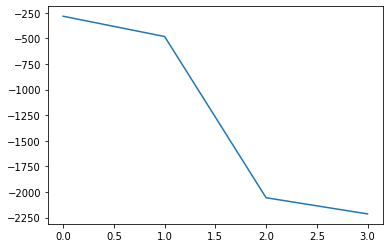

In [409]:
plt.plot(values)

In [418]:
min(values)

-2214.0

In [248]:
print(beta_min)

print(sum(weights))

C = 0.5*(min(values) + sum(weights))
print(C)

print(density)

print(k)
print(i)

0.0020138958815829216
-9931
-5461.0
50
8
9


alpha=0.8, beta=-0.09001996007984032


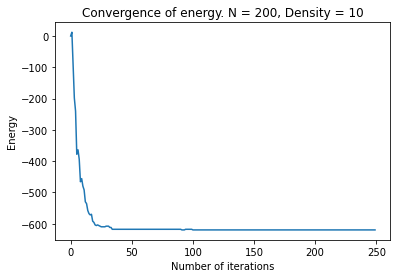

In [937]:
y = energy(250, N, i/10, beta_min + (k)*0.01, 1)
plt.title("Convergence of energy. N = {}, Density = {}".format(N, density))
plt.plot(y)
plt.ylabel("Energy")
plt.xlabel("Number of iterations")
print("alpha={}, beta={}".format(i/10, beta_min + (-2)*0.05))

In [938]:
y[-1]

-620.0

In [939]:
C = 0.5*(y[-1]+sum(weights))
C

-1312.0

In [696]:
energy(300, N, i/10, beta_min + (-1)*0.05)

-64.0

In [107]:
x, f, g, J = definitions(100, Tmax)
x = voltage(0.9, 0.04, 100, Tmax, x, f, g, J)

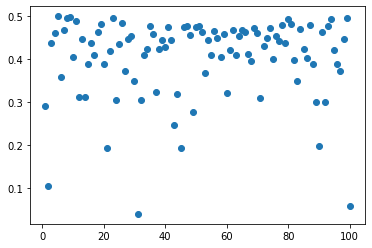

In [111]:
plt.scatter(np.linspace(1,100,100), abs(x[:,-1]))

In [124]:
max(sum(J))

-38.0